In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.base import clone
# import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from utils import get_file_paths, load_dfs_by_source
from lstm import Vanilla_LSTM
from lgbm import LgbmModel
# from evaluation import calc_metrics, plot_metrics
from lgbm_data_prep import train_val_test_split_original, LgbmDataPrep

2024-02-06 00:27:07.087204: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
x,v,t = train_val_test_split_original()

In [4]:
DATA_PATH = '/Users/orenben/Documents/runi/mlops-anomaly-detection/data/'
DATA_SOURCES = ['valve1','valve2','other']


In [5]:
data_dict_by_source = {source:load_dfs_by_source(DATA_PATH,source) for source in DATA_SOURCES}

In [6]:
valve1_df = data_dict_by_source['valve1']

In [7]:
model = LgbmModel()

In [8]:
x

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 10:14:33,0.026588,0.040111,1.330200,0.054711,79.3366,26.0199,233.062,32.0000,0.0,0.0
2020-03-09 10:14:34,0.026170,0.040453,1.353990,0.382638,79.5158,26.0258,236.040,32.0000,0.0,0.0
2020-03-09 10:14:35,0.026199,0.039419,1.540060,0.710565,79.3756,26.0265,251.380,32.0000,0.0,0.0
2020-03-09 10:14:36,0.026027,0.039641,1.334580,0.382638,79.6097,26.0393,234.392,32.0000,0.0,0.0
2020-03-09 10:14:37,0.026290,0.040273,1.078510,-0.273216,79.6109,26.0420,225.342,32.0000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-03-09 13:59:09,0.028142,0.039445,0.981651,0.382638,66.9901,24.7381,232.774,32.0000,0.0,0.0
2020-03-09 13:59:10,0.028283,0.040615,0.966102,0.054711,66.8982,24.7404,227.030,32.0226,0.0,0.0
2020-03-09 13:59:11,0.028778,0.041955,0.827491,-0.601143,66.8706,24.7499,228.784,32.9781,0.0,0.0


In [33]:
model.train(train_set=x)

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811


<Axes: >

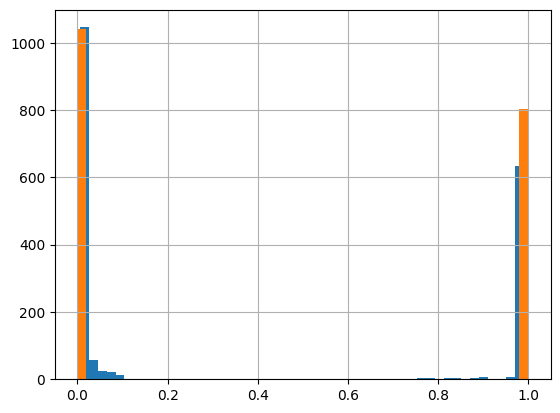

In [34]:
pd.Series(model.predict(t)).hist(bins=50)
pd.Series(model.y_test).hist(bins=50)

In [35]:
def calc_metrics(y_true,y_pred):
    accuracy = accuracy_score(y_true, np.where(y_pred>=0.5,1,0))
    cm = confusion_matrix(y_true, np.where(y_pred>=0.5,1,0))
    f1 = f1_score(y_true, np.where(y_pred>=0.5,1,0))
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    return accuracy,cm,f1,fpr, tpr, thresholds, roc_auc

In [36]:
accuracy,cm,f1,fpr, tpr, thresholds, roc_auc = calc_metrics(model.y_test,model.y_pred)

In [37]:
def plot_metrics(cm, fpr, tpr, roc_auc, thresholds, title = 'Model Evaluation Metrics'):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    fig.suptitle(title, fontsize=16, y=1.02)
    confusion_matrix_ax = ax[0]
    roc_curve_ax = ax[1]

    # Confusion Matrix in the first subplot
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=confusion_matrix_ax,cmap='Blues')
    confusion_matrix_ax.set_title('Confusion Matrix')
    confusion_matrix_ax.set_xlabel('Predicted labels')
    confusion_matrix_ax.set_ylabel('True labels')

    # ROC Curve in the second subplot
    roc_curve_ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    roc_curve_ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    roc_curve_ax.set_xlabel('False Positive Rate')
    roc_curve_ax.set_ylabel('True Positive Rate')
    roc_curve_ax.set_title('Receiver Operating Characteristic (ROC) Curve')
    roc_curve_ax.legend(loc='lower right')

    # Annotate some key thresholds on the curve
    # Select thresholds to annotate on the ROC curve
    indices_to_annotate = [0, len(thresholds) // 3, 2 * len(thresholds) // 3, -1]
    # for i in indices_to_annotate:
    #     roc_curve_ax.annotate(f'{thresholds[i]:.2f}', (fpr[i], tpr[i]), textcoords="offset points", xytext=(10,-5), ha='center')

    # Display the plot
    plt.tight_layout()
    plt.show()

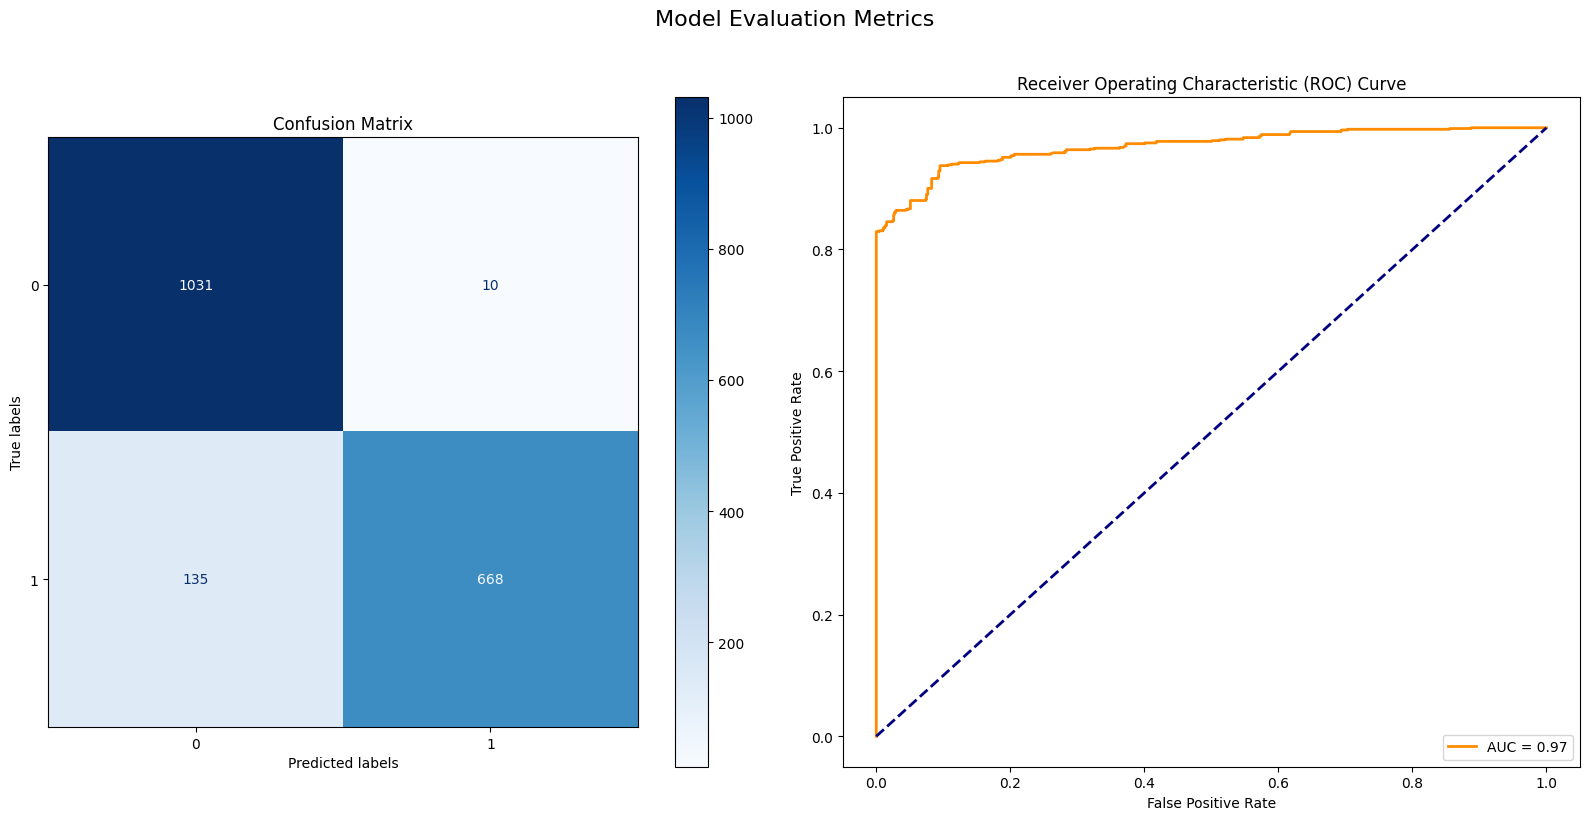

In [38]:
plot_metrics(cm,fpr, tpr,roc_auc,thresholds)

In [39]:

# from sklearn.model_selection import train_test_split
# from sklearn.base import clone
# from lightgbm import LGBMClassifier
# import numpy as np

def sample_model(x_train, model, n):
    rows = x_train.shape[0]
    sample_size = rows // n
    sample_models = []
    for _ in range(n):
        # Bootstrap sample
        x_train_sample = x_train.sample(n=sample_size, random_state=_)
        X = x_train_sample.drop('anomaly', axis=1)
        y = x_train_sample['anomaly']
        # Fit model
        model_clone = clone(model)  # Clone the base model to avoid refitting the same model
        model_clone.fit(X, y)
        sample_models.append(model_clone)
    return sample_models

# def train_models(x_train, y_train, model, n):
#     """
#     Trains the model n times on bootstrap samples of the training data.
    
#     Parameters:
#     - x_train: Features of the training data.
#     - y_train: Labels of the training data.
#     - model: The machine learning model to be trained.
#     - n: The number of times to fit the model on bootstrap samples.
    
#     Returns:
#     - models: A list of trained models.
#     """
#     models = []
#     for _ in range(n):
#         # Bootstrap sample
#         x_train_sample, _, y_train_sample, _ = train_test_split(
#             x_train, y_train, train_size=1/n, stratify=y_train, random_state=_)
#         # Fit model
#         model_clone = clone(model)  # Clone the base model to avoid refitting the same model
#         model_clone.fit(x_train_sample, y_train_sample)
#         models.append(model_clone)

#     return models

def test_models(x_test, models, operation_var):
    """
    Runs each model on the test data and calculates the probability of not being an anomaly.
    
    Parameters:
    - x_test: Features of the test data.
    - models: A list of trained models.
    - operation_var: Operation to perform on the probabilities ('max' or 'avg').
    
    Returns:
    - labels: The predicted labels for the test data.
    - test_not_anomaly_proba: The probability of not being an anomaly for each test sample.
    """
  
    probas = []
    for model in models:
        # Predict_proba returns [prob_anomaly, prob_not_anomaly] for binary classification
        
        anomaly_probs = model.predict_proba(x_test)
        prob_is_anomaly, prob_not_anomaly = anomaly_probs[:, 0], anomaly_probs[:, 1]
        probas.append(prob_not_anomaly)

    probas = np.array(probas)

    # Calculate test_not_anomaly_proba based on operation_var
    if operation_var == 'max':
        test_not_anomaly_proba = np.max(probas, axis=0)
    elif operation_var == 'avg':
        test_not_anomaly_proba = np.mean(probas, axis=0)
    else:
        raise ValueError("operation_var must be 'max' or 'avg'")
    
    # Convert probabilities to labels
    labels = np.where(test_not_anomaly_proba < 0.5, 0, 1)
    
    return labels, test_not_anomaly_proba



total_rows = len(valve1_df)
index_70_percent = int(total_rows * 0.7)
index_90_percent = index_70_percent + int(total_rows * 0.2)

# Split the DataFrame into three parts
test_df = valve1_df.iloc[index_90_percent:] 
train_df = valve1_df.iloc[:index_70_percent]
valid_df = valve1_df.iloc[index_70_percent:index_90_percent]


model = lgb.LGBMClassifier()  # Base LightGBM model


n = 50  # Number of models to train
sample_model_list = sample_model(train_df, model, n=n)

X_test = test_df.drop('anomaly', axis=1)
y_test = test_df['anomaly']

max_labels, max_probabilities = test_models(X_test, sample_model_list, operation_var='max')
avg_labels, avg_probabilities = test_models(X_test, sample_model_list, operation_var='avg')

# Train sample models
# X_train = train_df.drop('anomaly', axis=1)
# y_train = train_df['anomaly']

# models_list = train_models(X_train, y_train, model, n=n)

# X_test = test_df.drop('anomaly', axis=1)
# y_test = test_df['anomaly']

# max_labels, max_probabilities = test_models(X_test, models_list, operation_var='max')
# avg_labels, avg_probabilities = test_models(X_test, models_list, operation_var='avg')


NameError: name 'lgb' is not defined

In [ ]:
# avg_labels, avg_probabilities
accuracy, cm, f1, fpr, tpr, thresholds, roc_auc = calc_metrics(y_test,avg_labels)
plot_metrics(cm, fpr, tpr, roc_auc, thresholds, title = 'Average Probability')
accuracy, f1, thresholds